In [1]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

from math import pi
import scipy
import re

In [2]:
pd.options.display.max_columns=200
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
path_escape_met="../results/data/raw_data_gie_hmf.tsv" # change this with your path
path_escape_pr="../results/data/raw_data_gie_pcawg.tsv" # change this with your path

In [3]:
def prepare_metadata():
    df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")
    df_meta=df_meta[(df_meta["is_selected"]==True)]
    return df_meta


In [4]:
df_met = pd.read_csv(f"{path_escape_met}",sep="\t").rename(columns={"sample":"sample_id"})
df_primary = pd.read_csv(f"{path_escape_pr}",sep="\t").rename(columns={"sample":"sample_id"})
df = pd.concat([df_met,df_primary])
df_metadata = prepare_metadata()
df=df.merge(df_metadata)



### Clonality per sample 

In [5]:
df_clonality_timing = pd.read_csv("/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/analysis/dna-rep-ann/final-update/r-objects/all-purple-timing.txt.gz",sep="\t")
df_clonality_timing["frac_clonal"] = df_clonality_timing["clonal_tmb_80_cutoff"] / (df_clonality_timing["clonal_tmb_80_cutoff"]+df_clonality_timing["subclonal_tmb_80_cutoff"])

In [6]:
df = df.merge(df_clonality_timing[["sample_id","frac_clonal"]],how="left")

### Annotate clonal and subclonal GIE

In [7]:
allowed_csq = set(["frameshift_variant","stop_gained","stop_lost","splice_acceptor_variant","splice_donor_variant","stop_gained","splice_region_variant","start_lost"]) # monoallelic
allowed_csq_biallelic = set(["missense_variant","structural_interaction_variant","conservative_inframe_deletion","conservative_inframe_insertion","disruptive_inframe_deletion","disruptive_inframe_insertion"]) # only biallelic 
alterations = pd.read_csv("../metadata/immune_selected_genes.tsv",sep="\t")
alterations=alterations[alterations["Selected"]]

def app_pathway(row,clonal=True):
    selected_genes = alterations[alterations["Pathway_general"]=="Antigen Presentation Pathway"]["Gene"].values
    for gene in selected_genes:
        if (is_clonally_mutated(gene,row["mut_scaffold_mhc"],clonal) or (is_clonally_mutated(gene, row["mut_tfs"],clonal)) or (is_clonally_mutated(gene, row["mut_transport_mhc"],clonal))):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])
            
def ifn_gamma_pathway(row,clonal=True):
    selected_genes=alterations[alterations["Pathway_general"]=="IFN-gamma pathway"]["Gene"].values
    for gene in selected_genes:

        if (is_clonally_mutated(gene,row["mut_interferon"],clonal)):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])

def cd58_pathway(row,clonal=True):
    selected_genes=["CD58"]
    for gene in selected_genes:
      
        if (is_clonally_mutated(gene,row["mut_cd58"],clonal)):
            return pd.Series([True, f"mut {gene}"])
    return pd.Series([False,""])



def is_clonally_mutated(gene,muts,clonal=True):
    if not(";") in str(muts):
        return False
    muts_gene=0
    if not(clonal):
        clonal="subclonal"
    else:
        clonal="clonal"
    for mut in muts.split("___"):
       
        gene_mut,csq,allelic_status,germline_status,clonality_purple,clonality_timing,af,cn,macn=mut.split(";")
         
        if gene == gene_mut and (clonality_purple.startswith(clonal))  and (len(set(csq.split("&")).intersection(allowed_csq))) >0: 
            return True # At least one clonal deleterios mutations
        if gene == gene_mut and (clonality_purple.startswith(clonal)) and allelic_status == "biallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0 :
            return True # At least one biallelic deleterios or non-synonymous likely impactful mutation (missense)
        if gene == gene_mut and (clonality_purple.startswith(clonal)) and allelic_status == "monoallelic" and (len(set(csq.split("&")).intersection(allowed_csq_biallelic))) >0:
            muts_gene+=1 # multiple non-synonymous monoallelic mutations
    return muts_gene>1 # multipl, at least two, non-synonymous monoallelic mutations

In [8]:
# clonal
df[["systemic_app_pathway_clonal","systemic_app_pathway_detail_clonal"]]  = df.apply(lambda row: app_pathway(row),axis=1)          
df[["cd58_pathway_clonal","cd58_pathway_detail_clonal"]]  = df.apply(lambda row: cd58_pathway(row),axis=1)          
df[["ifn_gamma_pathway_clonal","ifn_gamma_pathway_detail_clonal"]]  = df.apply(lambda row: ifn_gamma_pathway(row),axis=1)          
# subclonal
df[["systemic_app_pathway_subclonal","systemic_app_pathway_detail_subclonal"]]  = df.apply(lambda row: app_pathway(row,clonal=False),axis=1)          
df[["cd58_pathway_subclonal","cd58_pathway_detail_subclonal"]]  = df.apply(lambda row: cd58_pathway(row,clonal=False),axis=1)          
df[["ifn_gamma_pathway_subclonal","ifn_gamma_pathway_detail_subclonal"]]  = df.apply(lambda row: ifn_gamma_pathway(row,clonal=False),axis=1)          


### HLA mutations

In [9]:
# get the clonality of mutations in HLA-genes
m=re.compile("SUBCL=([0-9\.e\-]+)")
l=[]
for sample_id in df[df["mut_hla_lilac"]]["sample_id"]:
    if "DO" in sample_id:
        try:
             dq = pd.read_csv(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/pcawg/lilac/{sample_id}/{sample_id}.lilac.somatic.vcf.gz",sep="\t",skiprows=91)
        except:
            dq = pd.read_csv(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/pcawg/lilac/{sample_id}/{sample_id}.lilac.somatic.vcf.gz",sep="\t",skiprows=97)
    else:
        try:
            dq = pd.read_csv(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac/{sample_id}/{sample_id}.lilac.somatic.vcf.gz",sep="\t",skiprows=94)
        except:
            dq = pd.read_csv(f"/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac/{sample_id}/{sample_id}.lilac.somatic.vcf.gz",sep="\t",skiprows=97)

    for i,r in dq.iterrows():
        
        csq = r["INFO"].split("|")[1]
        try:
            clonal_v=float(m.search(r["INFO"])[1])
        except:
            clonal_v=0.0
        l.append([sample_id,csq,clonal_v])
df_hla_cl = pd.DataFrame(l,columns=["sample_id","csq","subclonal_likelihood"])
    



In [10]:
df_hla_cl["is_clonal_hla"] = df_hla_cl["subclonal_likelihood"] <= 0.8
df_hla_cl["is_subclonal_hla"] = df_hla_cl["subclonal_likelihood"] > 0.8
df_hla = df_hla_cl[df_hla_cl["csq"]!="synonymous_variant"].groupby(["sample_id"],as_index=False).agg({"is_clonal_hla":np.any,"is_subclonal_hla":np.any})
df = df.merge(df_hla,how="left")

### Compute, for every cancer type and mutation type the frequency of clonal and subclonal GIE events

In [11]:
df["escape_clonal"] = df["systemic_app_pathway_clonal"] | df["cd58_pathway_clonal"] | df["ifn_gamma_pathway_clonal"] | df["is_clonal_hla"] 
df["escape_subclonal"] = df["systemic_app_pathway_subclonal"] | df["cd58_pathway_subclonal"] | df["ifn_gamma_pathway_subclonal"] | df["is_subclonal_hla"]

In [12]:
summary_cohort = pd.read_csv("../metadata/table_cancer_types_info.tsv",sep="\t")
ttypes = list(summary_cohort[(summary_cohort["group_HMF"]==True)|(summary_cohort["group_PCAWG"]==True)]["cancer_type"])

In [13]:
counts_samples=df.groupby(["cancer_type","cohort"],as_index=False).agg({"sample_id":"count"})

In [14]:
summary_clonality=df[df["cancer_type"].isin(ttypes)].groupby(["cancer_type","cohort"],as_index=False).agg(dict([ (x,np.nansum) for x in ["systemic_app_pathway_clonal","cd58_pathway_clonal","ifn_gamma_pathway_clonal","is_clonal_hla",
                                                     "systemic_app_pathway_subclonal","cd58_pathway_subclonal","ifn_gamma_pathway_subclonal","is_subclonal_hla",
                                                                                                       "escape_clonal","escape_subclonal"]])).merge(counts_samples)
summary_clonality["freq_clonal"] = summary_clonality.apply(lambda row: row["escape_clonal"] / row["sample_id"],axis=1)
summary_clonality["freq_subclonal"] = summary_clonality.apply(lambda row: row["escape_subclonal"] / row["sample_id"],axis=1)

In [15]:
summary_clonality.sort_values("freq_subclonal")

,cancer_type,cohort,systemic_app_pathway_clonal,cd58_pathway_clonal,ifn_gamma_pathway_clonal,is_clonal_hla,systemic_app_pathway_subclonal,cd58_pathway_subclonal,ifn_gamma_pathway_subclonal,is_subclonal_hla,escape_clonal,escape_subclonal,sample_id,freq_clonal,freq_subclonal
31,Mesothelioma,Hartwig,1,0,0,0,0,0,0,0,1,0,38,0.026316,0.000000
28,Lung neuroendocrine,Hartwig,0,0,1,0,0,0,0,0,1,0,22,0.045455,0.000000
29,Medulloblastoma,Hartwig,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000
30,Medulloblastoma,PCAWG,1,0,0,0,0,0,0,0,1,0,106,0.009434,0.000000
61,Uterus carcinoma,Hartwig,1,0,4,2,0,0,0,0,4,0,33,0.121212,0.000000
34,Oligodendroglioma,PCAWG,0,0,0,0,0,0,0,0,0,0,18,0.000000,0.000000
35,Osteosarcoma,PCAWG,0,0,0,0,0,0,0,0,0,0,32,0.000000,0.000000
36,Ovarian cancer,Hartwig,2,0,1,1,0,0,0,0,4,0,165,0.024242,0.000000
38,Pancreas carcinoma,Hartwig,0,0,1,2,0,0,0,0,3,0,99,0.030303,0.000000
40,Pancreas neuroendocrine,Hartwig,1,0,0,0,0,0,0,0,1,0,37,0.027027,0.000000


### Plot clonality frequency compared to overall plot

##### Hartwig

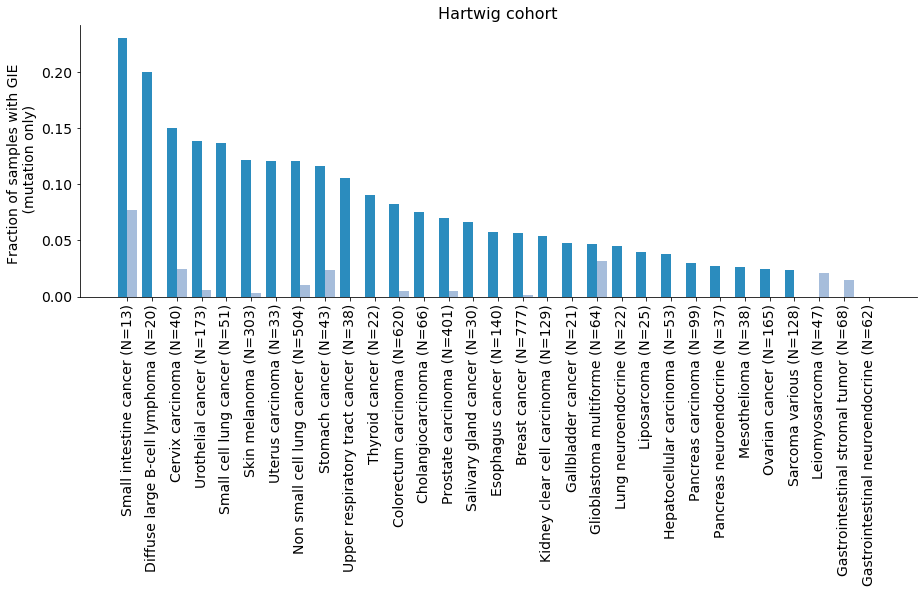

In [21]:
# Hartig overall picture
fig,ax=plt.subplots(figsize=(15,5))
labels=[]
ttypes_hmf=list(summary_cohort[(summary_cohort["group_HMF"]==True)]["cancer_type"])
scs=summary_clonality[(summary_clonality["cancer_type"].isin(ttypes_hmf))&(summary_clonality["cohort"]=="Hartwig")].sort_values("freq_clonal",ascending=False)["cancer_type"].values
for i,ttype in enumerate(scs):
    sc=summary_clonality[(summary_clonality["cancer_type"]==ttype)&(summary_clonality["cohort"]=="Hartwig")]
    ax.bar(x=i-0.2,height=sc["freq_clonal"],width=0.4,color="#2b8cbe")
    ax.bar(x=i+0.2,height=sc["freq_subclonal"],width=0.4,color="#a6bddb")
    samples=sc["sample_id"].values[0]
    labels.append(ttype + f" (N={samples})")
ax.set_xticks(list(range(len(labels))))
_=ax.set_xticklabels(labels,rotation=90)
ax.set_title("Hartwig cohort",fontsize=16)
ax.set_ylabel("Fraction of samples with GIE \n (mutation only)",fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'hartwig_subclonal_freq.pdf', dpi=800,bbox_inches="tight")

##### PCAWG

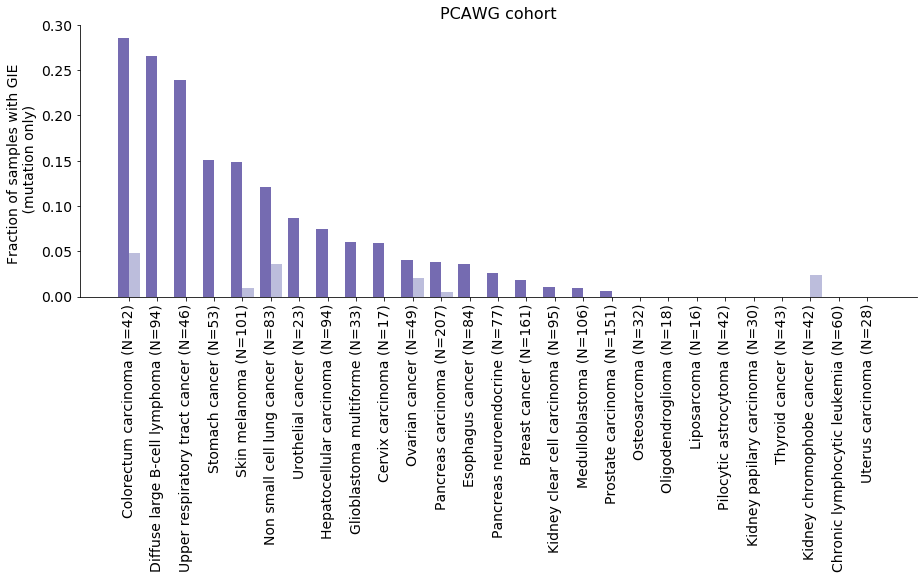

In [22]:
# PCAWG overall picture
fig,ax=plt.subplots(figsize=(15,5))
labels=[]
ttypes_hmf=list(summary_cohort[(summary_cohort["group_PCAWG"]==True)]["cancer_type"])
scs=summary_clonality[(summary_clonality["cancer_type"].isin(ttypes_hmf))&(summary_clonality["cohort"]=="PCAWG")].sort_values("freq_clonal",ascending=False)["cancer_type"].values
for i,ttype in enumerate(scs):
    sc=summary_clonality[(summary_clonality["cancer_type"]==ttype)&(summary_clonality["cohort"]=="PCAWG")]
    ax.bar(x=i-0.2,height=sc["freq_clonal"],width=0.4,color="#756bb1")
    ax.bar(x=i+0.2,height=sc["freq_subclonal"],width=0.4,color="#bcbddc")
    samples=sc["sample_id"].values[0]
    labels.append(ttype + f" (N={samples})")
ax.set_xticks(list(range(len(labels))))
_=ax.set_xticklabels(labels,rotation=90)
ax.set_title("PCAWG cohort",fontsize=16)
ax.set_ylabel("Fraction of samples with GIE \n (mutation only)",fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig(f'pcawg_subclonal_freq.pdf', dpi=800,bbox_inches="tight")

### Compute frequency of subclonal evolutioN in MSI

In [30]:
counts_samples=df[df["msi_status"]=="MSI"].groupby(["cancer_type","cohort"],as_index=False).agg({"sample_id":"count"})
summary_clonality_msi=df[(df["cancer_type"].isin(ttypes))&(df["msi_status"]=="MSI")].groupby(["cancer_type","cohort"],as_index=False).agg(dict([ (x,np.nansum) for x in ["systemic_app_pathway_clonal","cd58_pathway_clonal","ifn_gamma_pathway_clonal","is_clonal_hla",
                                                     "systemic_app_pathway_subclonal","cd58_pathway_subclonal","ifn_gamma_pathway_subclonal","is_subclonal_hla",
                                                                                                       "escape_clonal","escape_subclonal"]])).merge(counts_samples)
summary_clonality_msi["freq_clonal"] = summary_clonality_msi.apply(lambda row: row["escape_clonal"] / row["sample_id"],axis=1)
summary_clonality_msi["freq_subclonal"] = summary_clonality_msi.apply(lambda row: row["escape_subclonal"] / row["sample_id"],axis=1)
summary_clonality_msi[summary_clonality_msi["escape_clonal"]>4][["cancer_type","cohort","freq_clonal","freq_subclonal"]]

,cancer_type,cohort,freq_clonal,freq_subclonal
3,Colorectum carcinoma,Hartwig,0.774194,0.096774
4,Colorectum carcinoma,PCAWG,1.000000,0.200000
11,Non small cell lung cancer,Hartwig,1.000000,0.000000
14,Prostate carcinoma,Hartwig,0.764706,0.058824


In [32]:
v=df[(df["escape_subclonal"])&~(df["escape_clonal"])]["cancer_type"].value_counts()/df["cancer_type"].value_counts()
v.sort_values()

Breast cancer                      0.001066
Colorectum carcinoma               0.003021
Pancreas carcinoma                 0.003268
Prostate carcinoma                 0.003623
Ovarian cancer                     0.004673
Skin melanoma                      0.004950
Urothelial cancer                  0.005102
Non small cell lung cancer         0.013629
Gastrointestinal stromal tumor     0.014706
Leiomyosarcoma                     0.016393
Cervix carcinoma                   0.017544
Glioblastoma multiforme            0.020619
Kidney chromophobe cancer          0.023810
CNS cancer mixed                   0.083333
Testis cancer                      0.200000
Lymphoma mixed                     0.200000
Thymus neuroendocrine              1.000000
Acute myeloid leukemia                  NaN
Adrenal gland cancer                    NaN
Bone benign tumor                       NaN
CUP                                     NaN
Cholangiocarcinoma                      NaN
Chronic lymphocytic leukemia    

In [157]:
df[(df["escape_subclonal"])&(df["escape_clonal"])]["cancer_type"].value_counts()

Colorectum carcinoma      3
Small intestine cancer    1
Stomach cancer            1
Name: cancer_type, dtype: int64

In [33]:
df[(df["escape_subclonal"])&~(df["escape_clonal"])][["sample_id","cancer_type","cohort","smnv_load","msStatus","loh_lilac","del_transport_mhc","del_scaffold_mhc","del_interferon","del_tfs","systemic_app_pathway_subclonal","cd58_pathway_subclonal","ifn_gamma_pathway_subclonal","is_subclonal_hla","frac_clonal"]].sort_values("smnv_load")

,sample_id,cancer_type,cohort,smnv_load,msStatus,loh_lilac,del_transport_mhc,del_scaffold_mhc,del_interferon,del_tfs,systemic_app_pathway_subclonal,cd58_pathway_subclonal,ifn_gamma_pathway_subclonal,is_subclonal_hla,frac_clonal
4165,WIDE01011042T,Gastrointestinal stromal tumor,Hartwig,2576.0,MSS,False,NaN,NaN,NaN,NaN,False,False,False,True,NaN
5923,DO220510,Kidney chromophobe cancer,PCAWG,3325.0,MSS,True,NaN,NaN,NaN,NaN,True,False,False,NaN,NaN
1830,CPCT02100089T,CNS cancer mixed,Hartwig,4411.0,MSS,False,NaN,NaN,NaN,NaN,False,False,True,NaN,NaN
3914,WIDE01010225T,Testis cancer,Hartwig,8293.0,MSS,True,NaN,NaN,NaN,NaN,False,False,True,NaN,NaN
379,DRUP01060020T,Glioblastoma multiforme,Hartwig,11178.0,MSS,False,NaN,NaN,NaN,NaN,False,False,False,True,0.798067
6031,DO25068,Non small cell lung cancer,PCAWG,13992.0,MSS,True,NaN,NaN,NaN,NaN,False,False,False,True,0.030815
5984,DO31150,Ovarian cancer,PCAWG,14003.0,MSS,False,NaN,NaN,NaN,NaN,False,False,True,NaN,0.700813
6226,DO221541,Pancreas carcinoma,PCAWG,14891.0,MSS,False,NaN,NaN,NaN,NaN,True,False,False,NaN,0.660294
968,WIDE01010619T,Non small cell lung cancer,Hartwig,14942.0,MSS,False,NaN,NaN,NaN,NaN,True,False,False,NaN,0.989354
3560,CPCT02300038T,Lymphoma mixed,Hartwig,15492.0,MSS,False,NaN,NaN,NaN,NaN,True,False,False,NaN,NaN


In [193]:
df[(df["escape_subclonal"])&~(df["escape_clonal"])&(df["cancer_type"]=="Non small cell lung cancer")]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,systemic_app_pathway_clonal,systemic_app_pathway_detail_clonal,cd58_pathway_clonal,cd58_pathway_detail_clonal,ifn_gamma_pathway_clonal,ifn_gamma_pathway_detail_clonal,systemic_app_pathway_subclonal,systemic_app_pathway_detail_subclonal,cd58_pathway_subclonal,cd58_pathway_detail_subclonal,ifn_gamma_pathway_subclonal,ifn_gamma_pathway_detail_subclonal,is_clonal_hla,is_subclonal_hla,escape_clonal,escape_subclonal,frac_clonal
968,WIDE01010619T,0.0,0.0,0.0,1,1,1,3,3,3,NaN,NaN,NaN,NaN,NLRC5;stop_gained;monoallelic;germline_wt;subc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,12.302026,184.530387,6.775322,0.51,0.3225,True,MSS,LOW,5.226303,235,91,8,366,PASS,A*02:01,A*24:02,B*15:01,B*18:01,C*03:04,C*05:01,2.97,1.01,2.97,1.01,2.97,1.01,0.0,0.0,0.0,0.0,0.0,0.0,False,False,True,NaN,NaN,NaN,NaN,"HLA-A,HLA-C,HLA-B",NaN,64,0,HMF004715A,2971,Hartwig,HMF004715,NaN,NaN,NaN,Lung,Lung,Non small cell lung cancer,NSCLC,NaN,NaN,Unknown,0.51,1.0,1.0,1.0,True,2.44,MALE,True,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,False,235.0,14942.0,13717.0,311.0,859.0,13564.0,305.0,845.0,146.0,6.0,7.0,PASS,True,False,NaN,True,True,True,False,False,,False,,False,,True,mut NLRC5,False,,False,,NaN,NaN,False,True,0.989354
1081,WIDE01010238TII,0.0,0.0,0.0,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NLRC5;splice_acceptor_variant&intron_variant;m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,13.186740,197.801105,8.795580,0.81,0.0253,True,MSS,HIGH,28.322141,642,472,32,2780,PASS,A*01:01,A*02:01,B*40:01,B*51:01,C*03:04,C*14:02,1.95,2.00,1.95,2.00,1.95,2.00,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,147,0,HMF004203B,2879,Hartwig,HMF004203,NaN,NaN,NaN,Lung,Lung,Non small cell lung cancer,NSCLC,NaN,NaN,Unknown,0.81,1.0,1.0,1.0,True,3.30,MALE,True,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,False,642.0,80973.0,74156.0,2497.0,4037.0,64006.0,1929.0,3665.0,10078.0,573.0,316.0,PASS,True,False,NaN,True,True,True,False,False,,False,,False,,True,mut NLRC5,False,,False,,NaN,NaN,False,True,0.863988
1172,WIDE01010398T,0.0,0.0,0.0,2,2,2,3,3,3,NaN,B2M;stop_gained;monoallelic;germline_wt;subclo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,11.349724,113.497238,4.163904,0.28,0.0437,True,MSS,HIGH,23.295908,194,306,16,1394,PASS,A*02:01,A*02:01,B*15:01,B*51:01,C*03:04,C*14:02,3.02,1.94,3.02,1.94,3.02,1.94,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,24,0,HMF004469A,2931,Hartwig,HMF004469,NaN,NaN,NaN,Lung,Lung,Non small cell lung cancer,NSCLC,NaN,Na

In [182]:
df[df["sample_id"]=="DRUP01060020T"]

,sample_id,del_HLA-A,del_HLA-B,del_HLA-C,ploidy_minor_HLA-A,ploidy_minor_HLA-B,ploidy_minor_HLA-C,ploidy_major_HLA-A,ploidy_major_HLA-B,ploidy_major_HLA-C,mut_transport_mhc,mut_scaffold_mhc,mut_cd58,mut_interferon,mut_tfs,del_transport_mhc,del_cd58,del_scaffold_mhc,del_interferon,amps_inhibitors,del_tfs,epigenetic_regulators,n_germline_alleles,avg_divergence_germline,sum_diversity_germline,avg_diversity_locus,purity,diploidProportion,wholeGenomeDuplication,msStatus,tmlStatus,tmbPerMb,svTumorMutationalBurden,missense,frameshift,mnvs,QC_LILAC,A1,A2,B1,B2,C1,C2,A1_CN,A2_CN,B1_CN,B2_CN,C1_CN,C2_CN,A1_MUT,A2_MUT,B1_MUT,B2_MUT,C1_MUT,C2_MUT,loh_lilac,mut_hla_lilac,imbalance_lilac,loh_hfocal,loh_focal,loh_nonfocal,imbalance_hfocal,imbalance_focal,imbalance_nonfocal,total_fusions,total_reported_fusions,sample_id_2,index,cohort,patient_id,icgc_aliquot_id,icgc_specimen_id,icgc_sample_id,tissue_type,tissue_group,cancer_type,cancer_type_code,blacklist_comment,biopsy_site,simplified_biopsy_site,tumor_purity,tumor_purity_rank,n_biopsies_in_patient,n_cancer_types_in_patient,is_selected_biopsy,ploidy,gender,whole_genome_duplication,msi_status,hr_status,had_radiotherapy,had_other_treatment,had_chemotherapy,had_hormone_therapy,had_targeted_therapy,had_immunotherapy,treatment_info_available,sv_load,smnv_load,sbs_load,dbs_load,indel_load,sbs_load.clonal,dbs_load.clonal,indel_load.clonal,sbs_load.subclonal,dbs_load.subclonal,indel_load.subclonal,lilac_status,has_lilac,blacklisted_gie,blacklist_gie_comment,is_selected,has_group_cohort,has_group_mut_signatures,has_rna,systemic_app_pathway_clonal,systemic_app_pathway_detail_clonal,cd58_pathway_clonal,cd58_pathway_detail_clonal,ifn_gamma_pathway_clonal,ifn_gamma_pathway_detail_clonal,systemic_app_pathway_subclonal,systemic_app_pathway_detail_subclonal,cd58_pathway_subclonal,cd58_pathway_detail_subclonal,ifn_gamma_pathway_subclonal,ifn_gamma_pathway_detail_subclonal,is_clonal_hla,is_subclonal_hla,escape_clonal,escape_subclonal,frac_clonal
379,DRUP01060020T,0.0,0.0,0.0,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,11.548619,115.486188,5.202578,0.67,0.7774,False,MSS,LOW,3.909759,136,51,6,86,PASS,A*03:01,A*03:01,B*07:02,B*47:01,C*06:02,C*07:02,1.01,0.95,0.95,1.01,1.01,0.95,1.0,0.0,0.0,0.0,0.0,0.0,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,33,1,HMF002973A,2148,Hartwig,HMF002973,NaN,NaN,NaN,CNS,CNS,Glioblastoma multiforme,GBM,NaN,Primary,Local,0.67,1.0,1.0,1.0,True,2.02,MALE,False,MSS,HR_proficient,NaN,NaN,NaN,NaN,NaN,NaN,False,136.0,11178.0,9895.0,73.0,1197.0,8246.0,32.0,631.0,1641.0,43.0,562.0,PASS,True,False,NaN,True,True,True,False,False,,False,,False,,False,,False,,False,,False,True,False,True,0.798067


### WGD timing per sample

In [11]:
df_wgd_timing = pd.read_csv("/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0025_PCAWG_HMF/drivers/analysis/dna-rep-ann/final-update/r-objects/wgd-timing.txt",sep="\t")